
# 🏟️ Vila Olímpica — Classificação de Atletas por Altura e Peso (Machine Learning)

**Objetivo:** treinar modelos de **classificação** para prever a **modalidade esportiva** de um atleta
com base em **Altura (cm)** e **Peso (kg)**. As quatro classes são: **Basquete, Vôlei, Levantamento de Peso** e **Tênis de Mesa**.

## Contexto
Estamos organizando a **Vila Olímpica**. A equipe de credenciamento recebe somente **altura** e **peso** de cada atleta e precisa direcioná‑lo ao  dormitório correto.
Para isso, vamos **aprender um padrão** a partir de dados de atletas já conhecidos e então **classificar** novos atletas.

## O que é *Machine Learning*?
*Machine Learning* (ML) é quando **algoritmos aprendem padrões** a partir de dados de exemplo, **sem** que programemos regras fixas.  
Dado um conjunto de **entradas** (features ou inputs) e **saídas corretas** (rótulos, fornecidos nos dados de treino), o algoritmo ajusta seus parâmetros para **generalizar** para casos novos e, assim, produzir saídas preditivas (**outputs**).

## Modelos de **classificação**
Modelos de classificação recebem **features** e devolvem uma **classe**.  
Aqui, as features são **[Altura, Peso]** e a classe é a **modalidade**.  
Vamos treinar e comparar **três modelos** dos mais "clássicos":
1. **KNN (K-Nearest Neighbors)** — classifica observando as classes dos vizinhos mais próximos.  
2. **SVM com kernel RBF** — aprende uma fronteira que separa as classes maximizando margens.  
3. **Random Forest** — conjunto de várias árvores de decisão votando na classe final.

## Roteiro do notebook
1. Gerar **dados sintéticos** (quatro grupos com faixas de altura/peso coerentes com as modalidades).  
2. Dividir em **treino** e **teste**.  
3. Treinar KNN, SVM(RBF) e RandomForest (com *pipelines* de pré‑processamento quando necessário).  
4. Comparar **Acurácia** e **F1‑macro** e **escolher o melhor**.  
5. Inserir **novos casos manualmente** (alturas e pesos) e obter a previsão do melhor modelo.  
6. **Visualizar a fronteira de decisão** do melhor modelo.


## 1) Imports e configuração

In [25]:

# importa numpy para cálculos numéricos
import numpy as np  # operações matemáticas vetorizadas
# importa pandas para manipular tabelas
import pandas as pd  # dataframes
# importa matplotlib para gráficos
import matplotlib.pyplot as plt  # visualização E biblioteca de gráficos


# importa utilidades de ML do scikit-learn
from sklearn.model_selection import train_test_split  # separa treino/teste
from sklearn.metrics import accuracy_score, f1_score, classification_report  # métricas de avaliação
from sklearn.preprocessing import StandardScaler  # padronização (média 0, desvio 1)
from sklearn.pipeline import Pipeline  # encadear pré-processamento + modelo

# importa três algoritmos de classificação
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.svm import SVC  # SVM (classificador de vetores de suporte)
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória

# define semente global
np.random.seed(42)
random_state=42

## 2) Gerar dados sintéticos (Altura/Peso por modalidade)

In [26]:
n_por_classe = 150  # Serão 150 atletas por modalidade

# ===== Basquete =====
df_basquete = pd.DataFrame({
    "Altura_cm": np.random.normal(loc=200, scale=7, size=n_por_classe),
    "Peso_kg":   np.random.normal(loc=95,  scale=8, size=n_por_classe),
    "Modalidade": "Basquete"
})

# ===== Vôlei =====
df_volei = pd.DataFrame({
    "Altura_cm": np.random.normal(loc=195, scale=6, size=n_por_classe),
    "Peso_kg":   np.random.normal(loc=75,  scale=6, size=n_por_classe),
    "Modalidade": "Vôlei"
})

# ===== Levantamento de Peso =====
df_levp = pd.DataFrame({
    "Altura_cm": np.random.normal(loc=172, scale=6, size=n_por_classe),
    "Peso_kg":   np.random.normal(loc=115, scale=7, size=n_por_classe),
    "Modalidade": "Levantamento de Peso"
})

# ===== Tênis de Mesa =====
df_tm = pd.DataFrame({
    "Altura_cm": np.random.normal(loc=160, scale=5, size=n_por_classe),
    "Peso_kg":   np.random.normal(loc=60,  scale=5, size=n_por_classe),
    "Modalidade": "Tênis de Mesa"
})

# ===== Junta tudo em um único DataFrame =====
df = pd.concat([df_basquete, df_volei, df_levp, df_tm], ignore_index=True)#empilha os dataframes

df.head()


,Altura_cm,Peso_kg,Modalidade
0,203.476999,97.003943,Basquete
1,199.032150,97.771586,Basquete
2,204.533820,89.559802,Basquete
3,210.661209,96.858030,Basquete
4,198.360926,97.344580,Basquete


In [27]:
df.describe()

,Altura_cm,Peso_kg
count,600.000000,600.000000
mean,181.794884,86.681486
std,17.180510,22.252548
min,147.880603,45.518723
25%,165.354770,66.864076
50%,183.177256,83.929155
75%,197.213503,107.496487
max,217.242695,133.426674


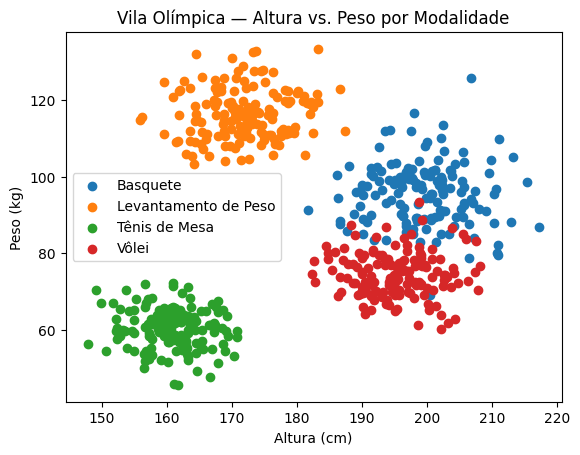

In [28]:
# ===== Gráfico de dispersão: Altura x Peso por Modalidade =====


plt.figure()  # cria uma nova figura

# percorre cada modalidade e plota seus pontos com rótulo para a legenda
for valor in sorted(df["Modalidade"].unique()):  # lista de classes (ordenada)
    mask = df["Modalidade"] == valor             # filtro para a modalidade atual
    plt.scatter(                                      # plota os pontos dessa modalidade
        df.loc[mask, "Altura_cm"],                    # eixo X: alturas
        df.loc[mask, "Peso_kg"],                      # eixo Y: pesos
        label=valor                              # nome na legenda
    )

# rótulos e título do gráfico
plt.xlabel("Altura (cm)")                             # nome do eixo X
plt.ylabel("Peso (kg)")                               # nome do eixo Y
plt.title("Vila Olímpica — Altura vs. Peso por Modalidade")  # título

plt.legend()  # exibe a legenda com os nomes das modalidades
plt.show()    # renderiza o gráfico


## 3) Separar dados em treino e teste

In [29]:
# ===== Separação em features (X) e rótulos (y) =====
# X = matriz de variáveis independentes (explicadoras, inputs do modelo)
#   → aqui usamos apenas as colunas numéricas: Altura e Peso
# y = vetor da variável dependente (explicada, output do modelo)
#   → aqui é a Modalidade do atleta (Basquete, Vôlei, etc.)

X = df[["Altura_cm", "Peso_kg"]].values  # matriz (linhas = atletas, colunas = características)
y = df["Modalidade"].values              # vetor (cada posição = rótulo da linha correspondente em X)

# ===== Divisão em treino e teste =====
# Objetivo: separar dados para que o modelo aprenda em uma parte (treino) e seja avaliado em outra (teste).
# Isso garante avaliação justa e mede a capacidade de generalização.
#
# train_test_split divide X e y em:
# - X_train, y_train → usados para treinar (70% dos dados)
# - X_test,  y_test  → usados para testar (30% dos dados)
#
# Parâmetros:
# - test_size=0.30   → 30% dos dados reservados para teste
# - random_state=42  → fixa a aleatoriedade, garantindo reprodutibilidade
# - stratify=y       → mantém a mesma proporção de classes (Basquete, Vôlei, etc.) nos dois conjuntos

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# ===== Conferindo os resultados =====
# .shape mostra dimensões (n_linhas, n_colunas) para X e (n_linhas,) para y
# Esperado:
# - X_train ≈ 70% das linhas originais, 2 colunas (Altura, Peso)
# - X_test  ≈ 30% das linhas originais, 2 colunas
# - y_train ≈ 70% dos rótulos
# - y_test  ≈ 30% dos rótulos

print("Formato do conjunto de treino (X_train):", X_train.shape)
print("Formato do conjunto de teste  (X_test):", X_test.shape)
print("Formato dos rótulos de treino (y_train):", y_train.shape)
print("Formato dos rótulos de teste  (y_test):", y_test.shape)


Formato do conjunto de treino (X_train): (420, 2)
Formato do conjunto de teste  (X_test): (180, 2)
Formato dos rótulos de treino (y_train): (420,)
Formato dos rótulos de teste  (y_test): (180,)


## 4) Configurar e Treinar os três modelos (KNN, SVM-RBF, RandomForest)

In [30]:
#Escolhi KNN, SVM e Random Forest porque esses três são modelos clássicos de classificação supervisionada.


# ====== KNN (K-Nearest Neighbors) ======
# Ideia: para classificar um atleta novo, o modelo olha para os "k vizinhos mais próximos"
# no espaço de Altura e Peso, e decide pela maioria.
# Exemplo: se 4 vizinhos são do Vôlei e 1 do Basquete → o atleta é classificado como Vôlei.
# Observação: o KNN é sensível à escala das variáveis (altura em cm pode "dominar" peso em kg),
# por isso usamos padronização (StandardScaler).
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),                     # padroniza dados (média 0, desvio 1)
    ("model", KNeighborsClassifier(n_neighbors=5))    # usa os 5 vizinhos mais próximos
])

# ====== SVM (Support Vector Machine) ======
# Ideia: encontra uma "fronteira" que separa as classes no espaço de dados,
# maximizando a margem entre elas (quanto mais distante, melhor).
# O kernel RBF (função radial) permite separar dados que não são linearmente separáveis,
# criando fronteiras curvas e mais flexíveis.
# Observação: também precisa de padronização, pois depende de distâncias no espaço.
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),              # padroniza altura e peso
    ("model", SVC(kernel="rbf",                # kernel radial (não linear)
                  C=3.0,                       # controla quão rígida é a margem
                  gamma="scale",               # ajusta influência de pontos individuais
                  probability=True,            # permite calcular probabilidades
                  random_state=42))            # semente fixa
])

# ====== Random Forest (Floresta Aleatória) ======
# Ideia: cria várias Árvores de Decisão independentes (cada árvore faz regras do tipo
# "se altura > 180 e peso < 80 então Vôlei") e combina todas as previsões por votação.
# Vantagem: muito robusto, lida bem com dados heterogêneos e não precisa de padronização.
rf_model = RandomForestClassifier(
    n_estimators=300,    # número de árvores na floresta (mais árvores = mais estabilidade)
    max_depth=None,      # profundidade máxima livre (árvores podem crescer bastante)
    random_state=42      # garante reprodutibilidade
)

# ====== Treinamento ======
# Cada modelo é treinado com os dados de treino (X_train, y_train).
# Nesse processo, cada algoritmo "aprende" padrões diferentes para classificar os atletas.
knn_pipeline.fit(X_train, y_train)  # ajusta KNN
svm_pipeline.fit(X_train, y_train)  # ajusta SVM
rf_model.fit(X_train, y_train)      # ajusta RandomForest


RandomForestClassifier(n_estimators=300, random_state=42)

## 5) Avaliar e comparar os modelos

In [31]:
# ===== Predições no conjunto de teste =====
# Cada modelo treinado será usado para prever a modalidade dos atletas do conjunto de teste (X_test).
# Importante: o modelo nunca "viu" esses dados durante o treino → servem para avaliar generalização.
y_pred_knn = knn_pipeline.predict(X_test)  # predição com KNN
y_pred_svm = svm_pipeline.predict(X_test)  # predição com SVM
y_pred_rf  = rf_model.predict(X_test)      # predição com RandomForest

# ===== Cálculo das métricas =====
# Para avaliar os resultados, vamos calcular:
# - Acurácia: proporção de acertos (predições corretas ÷ total)
# - F1-macro: média do F1-score entre as classes (boa para comparar quando temos várias classes)
# Obs: F1-score combina Precisão e Recall em uma única métrica.
acc_knn = accuracy_score(y_test, y_pred_knn)            # acurácia do KNN
f1_knn  = f1_score(y_test, y_pred_knn, average="macro") # F1-macro do KNN

acc_svm = accuracy_score(y_test, y_pred_svm)            # acurácia do SVM
f1_svm  = f1_score(y_test, y_pred_svm, average="macro") # F1-macro do SVM

acc_rf  = accuracy_score(y_test, y_pred_rf)             # acurácia do RandomForest
f1_rf   = f1_score(y_test, y_pred_rf, average="macro")  # F1-macro do RandomForest

# ===== Comparação dos modelos =====
# Imprimimos as métricas lado a lado para visualizar o desempenho de cada modelo.
print("==== Comparação de Modelos ====")
print(f"KNN         -> Acurácia: {acc_knn:.3f} | F1-macro: {f1_knn:.3f}")
print(f"SVM (RBF)   -> Acurácia: {acc_svm:.3f} | F1-macro: {f1_svm:.3f}")
print(f"RandomForest-> Acurácia: {acc_rf:.3f} | F1-macro: {f1_rf:.3f}")

# ===== Escolha do melhor modelo =====
# Critério: maior valor de F1-macro (mas poderíamos escolher outro critério, como acurácia ou tempo).
scores = {"KNN": f1_knn, "SVM": f1_svm, "RF": f1_rf}  # dicionário que mapeia modelo -> F1
melhor_nome = max(scores, key=scores.get)             # seleciona o modelo com maior F1
print(f"\nMelhor modelo (F1-macro): {melhor_nome}")   # imprime qual foi escolhido

# ===== Guarda o melhor modelo para uso futuro =====
# Assim podemos usar "melhor_modelo" sem precisar saber qual dos três venceu.
if melhor_nome == "KNN":
    melhor_modelo = knn_pipeline
elif melhor_nome == "SVM":
    melhor_modelo = svm_pipeline
else:
    melhor_modelo = rf_model

# ===== Relatório detalhado do melhor modelo =====
# classification_report mostra métricas por classe:
# - Precision (Precisão): entre os classificados como X, quantos realmente eram X?
# - Recall (Revocação): entre todos os X reais, quantos o modelo encontrou?
# - F1-score: equilíbrio entre Precisão e Recall
y_pred_best = melhor_modelo.predict(X_test)  # predição final com o melhor modelo
print("\nRelatório do melhor modelo:\n")
print(classification_report(y_test, y_pred_best))


==== Comparação de Modelos ====
KNN         -> Acurácia: 0.967 | F1-macro: 0.967
SVM (RBF)   -> Acurácia: 0.967 | F1-macro: 0.967
RandomForest-> Acurácia: 0.956 | F1-macro: 0.955

Melhor modelo (F1-macro): KNN

Relatório do melhor modelo:

                      precision    recall  f1-score   support

            Basquete       0.91      0.96      0.93        45
Levantamento de Peso       1.00      1.00      1.00        45
       Tênis de Mesa       1.00      1.00      1.00        45
               Vôlei       0.95      0.91      0.93        45

            accuracy                           0.97       180
           macro avg       0.97      0.97      0.97       180
        weighted avg       0.97      0.97      0.97       180



Como meu dataset é simulado e balanceado, Acurácia e F1-score saíram praticamente iguais.

Quando os dados são equilibrados, tanto acurácia quanto F1 funcionam bem. Quando os dados são desbalanceados, geralmente usamos F1. Geralmente escolhemos pelo F1-macro porque ele dá peso igual a todas as classes e evita que o modelo "pise" nas classes pequenas.

## 6) Prever manualmente (insira alturas/pesos)

In [32]:

# define uma função utilitária para prever a modalidade de novos atletas
def prever_modalidade(lista_alturas_pesos):
    # converte lista de tuplas (altura, peso) em array 2D
    X_novos = np.array(lista_alturas_pesos, dtype=float)  # garante tipo numérico
    # usa o melhor_modelo treinado para prever classes
    pred = melhor_modelo.predict(X_novos)  # retorna array de strings com as modalidades
    # cria um DataFrame bonito para exibir resultados
    saida = pd.DataFrame(X_novos, columns=["Altura_cm", "Peso_kg"])  # monta tabela
    saida["Modalidade_prevista"] = pred  # anexa coluna de previsão
    return saida  # retorna tabela

# EXEMPLO: edite os valores abaixo para testar diferentes casos
novos_atletas = [
    (205, 98),   # atleta alto e relativamente pesado
    (194, 74),   # atleta alto e mais leve
    (170, 118),  # atleta mais baixo e bem pesado
    (158, 58),   # atleta baixo e leve
    (182, 82)    # caso intermediário
]  # lista de (altura, peso)

# chama a função de previsão e mostra o resultado
prever_modalidade(novos_atletas)  # imprime a tabela com modalidades previstas


,Altura_cm,Peso_kg,Modalidade_prevista
0,205.0,98.0,Basquete
1,194.0,74.0,Vôlei
2,170.0,118.0,Levantamento de Peso
3,158.0,58.0,Tênis de Mesa
4,182.0,82.0,Vôlei


## 7) Visualizar a fronteira de decisão do melhor modelo

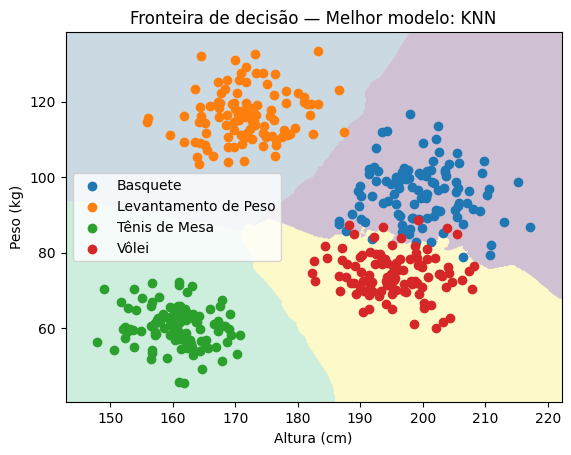

In [34]:

# separa pontos de treino por classe para plotar
classes = np.unique(y_train)  # obtém nomes das classes
# define limites do grid com base nos dados

x_min, x_max = X[:,0].min() - 5, X[:,0].max() + 5
y_min, y_max = X[:,1].min() - 5, X[:,1].max() + 5

# cria uma malha (grid) de pontos em todo o espaço de features
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),  # 400 pontos em altura
    np.linspace(y_min, y_max, 400)   # 400 pontos em peso
)  # grade de avaliação

# empilha o grid em uma matriz N x 2 para passar ao modelo
grid_points = np.c_[xx.ravel(), yy.ravel()]  # combina colunas em pares (altura,peso)

# calcula a previsão do melhor modelo para cada ponto da malha
Z = melhor_modelo.predict(grid_points)  # vetor de rótulos
# mapeia rótulos para inteiros para poder desenhar com imshow
labels_to_int = {label:i for i,label in enumerate(classes)}  # dicionário label->id
Z_int = np.vectorize(labels_to_int.get)(Z)  # converte rótulos para inteiros
Z_int = Z_int.reshape(xx.shape)  # remodela para o formato do grid

# plota a fronteira de decisão como uma imagem de fundo
plt.figure()  # cria figura
plt.imshow(
    Z_int,                    # matriz de classes
    origin="lower",           # origem no canto inferior esquerdo
    extent=(x_min, x_max, y_min, y_max),  # define limites
    alpha=0.25,               # transparência para ver pontos por cima
    aspect="auto"             # não forçar quadrado
)  # desenha regiões do classificador

# plota os pontos de treino por classe
for c in classes:  # para cada modalidade
    mask = (y_train == c)  # seleciona exemplos dessa classe
    plt.scatter(
        X_train[mask, 0],  # alturas
        X_train[mask, 1],  # pesos
        label=c            # rótulo da legenda
    )  # desenha pontos

# legenda e rótulos dos eixos
plt.legend()  # mostra legenda com nomes das classes
plt.xlabel("Altura (cm)")  # rótulo eixo x
plt.ylabel("Peso (kg)")    # rótulo eixo y
plt.title(f"Fronteira de decisão — Melhor modelo: {melhor_nome}")  # título da figura
plt.show()  # exibe o gráfico
